In [1]:
import os
try:
    import sirius 
    print('SiRIUS version',sirius.__version__,'already installed.')
except ImportError as e:
    print(e)
    print('Installing SiRIUS')
    os.system("pip install sirius")
    import sirius 
    print('SiRIUS version',sirius.__version__,' installed.')

import pkg_resources
import xarray as xr
import numpy as np

try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
    %matplotlib widget
except:
    IN_COLAB = False
    %matplotlib inline
    
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
import pkg_resources
import glob
import shutil

from casatools import image
from casatasks import tclean

from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from sirius import simulation
from sirius.dio import make_time_xda
from sirius.dio import make_chan_xda
from sirius_data.beam_1d_func_models.airy_disk import vla 
from sirius._sirius_utils._coord_transforms import _calc_rotation_mats, _directional_cosine,  _sin_project


xr.set_options(display_style="html")

SiRIUS version 0.0.32 already installed.


# Noise Calculation and Verification

The goal of this notebook is to verify the theoretical noise calculation found in the __Noise Theory__ section using SiRIUS for manual noise simulation. This is done using the following steps:
 - Use SiRIUS to do a noise only (no source) simulation.
 - Analytical calculation of the RMS noise of the resulting image.
 - Calculation of the expected noise using the method found in __Noise Theory__.

## Noise Theory

### SiRIUS tsys-manual noise calculation

The following explanation is partially based on pages 188-192 in Thompson et al.'s second edition of  Interferometry and Synthesis in Radio Astronomy.

The <b>system temperature (K)</b> (with the zenith atmospheric opacity $\tau=0$)* is:
\begin{align}
T_{sys} &= T_{rx} + T_{atmos}(1 - \eta_{spill} ) + T_{cmb}\\
\end{align}
where
 - $T_{rx}$ is the receiver temperature ($K$),
 - $T_{atmos}$ is the atmospheric temperature ($K$),
 - $\eta_{spill}$ is the forward spillover efficiency,
 - $T_{cmb}$ is the cosmic microwave background temperature ($K$).
*In a future release the atmospheric opacity will be included.

The <b>effective dish area ($m^2$)</b> for baseline $ij$:
\begin{align}
A^{eff}_{ij} = \eta_a \frac{\pi d_i d_j}{4}
\end{align}
where
 - $\eta_a$ is the antenna efficiency,
 - $d_{i/j}$ is the dish diamter of the $i/j$ antenna.

The <b>rms noise level (Jy)</b> at the correlator for the $ij$ baseline for a single component of the visibility (real or complex):
\begin{align}
\sigma_{ij} = \frac{\sqrt{2} k_b T_{sys} × 10^{26}}{A^{eff}_{i,j} \eta_q \eta_{cor} \sqrt{\Delta t \Delta \nu}}
\end{align}
where
- $k_b = 1.38064852 × 10^{-23} m^2 \: kg \: s^{-2} K^{-1}$ is Boltzmann's constant,
- $10^{26}$ is the factor that converts from $J m^{-2}$ to $Jy$.
- $\eta_q$ is the digitizer quantization efficiency,
- $\eta_{cor}$ is the correlator efficiency,
- $\Delta t$ is the correlator dump time (Seconds),
- $\Delta \nu$ is the bandwidth of a single channel (Hertz).

SiRIUS will save the following values to the main table of the measuremnet set (version 2):
\begin{align}
SIGMA_{ij} &= \sigma_{ij}, \\
WEIGHT_{ij} &= \frac{1}{\sigma_{ij}^2}.
\end{align}

In the synthesized map, with natural weighting, the flux density of a point source for which the peak response is equal to the rms noise level is given by:
\begin{align}
S_{rms} = \sqrt{1/\left( \sum^{n_{t}} \sum^{n_{b}} \sum^{n_{chan}} \sum^{n_{pol}} \frac{1}{\sigma_{ij}^2} \right)} 
\end{align}
where
- $n_{t}$ is the number of time samples with dump time $\Delta t$,
- $n_{b} = \frac{n_a^2 - n_a}{2}$ is the number of baselines (no autocorrelations),
- $n_{chan}$ number of channels with bandwidth $\Delta \nu$,
- $n_{pol}$ number of instrumental polarizations used to create the image (for stokes I, $n_{pol} = 2$).

If $d=d_i = d_j$ ($\sigma_{ij}$ is no longer a function baseline) we can simplify the point source rms sensitivity to:
\begin{align}
S_{nat} = \frac{\sigma_{ij}}{\sqrt{n_{t} n_{b} n_{chan}n_{pol}}} = \frac{\sqrt{2} k_b T_{sys} × 10^{26}}{A^{eff} \eta_q \eta_{cor} \sqrt{ (n_t \Delta t) n_b (n_{chan} \Delta \nu) n_{pol}}} = \frac{\sqrt{2} k_b T_{sys} × 10^{26}}{A^{eff} \eta_q \eta_{cor} \sqrt{ t_{int} \nu_{int} n_b n_{pol}}} = \frac{2 k_b T_{sys} × 10^{26}}{A^{eff} \eta_q \eta_{cor} \sqrt{ t_{int} \nu_{int} n_a (n_a - 1) n_{pol}}}
\end{align}

where $t_{int} = n_{t} \Delta t$. When a weighting scheme is added:
\begin{align}
S_{wgt} = \frac{S_{nat}}{\eta_{wgt}} = S_{nat} \frac{\sqrt{\sum w_i^2}}{\sum w_i}.
\end{align}

The <b>antenna system equivalent flux density ($Jy$)</b>:
\begin{align}
SEFD &= \frac{2 k_b T_{sys}}{\eta_q A^{eff}} × 10^{26} \\
\end{align}

\begin{align}
S_{wgt} &= \frac{\sqrt{2} SEFD }{\eta_{wgt} \eta_{cor} \sqrt{ t_{int} \nu_{int} n_a (n_a - 1) n_{pol}}} .
\end{align}

\begin{align}
t_{int} =  \frac{t_{int,nat}}{\eta_{wgt}^2} = \frac{2 n_{wgt}^2 SEFD^2}{\eta_{wgt}^2 S_{wgt}^2 \eta^2_{cor} \nu_{int} n_a (n_a - 1) n_{pol}}
\end{align}


## Helper Functions

In [2]:
def effective_dish_area(d_i: float, d_j: float, n_antenna=0.8)->float:
    '''
        Calculate effective dish area.
    '''
    
    return 0.25*n_antenna*np.pi*(d_i*d_j)

def system_temp(t_receiver_temp=50.0, t_atmosphere=250.0, n_spill=0.85, t_microwave_background=2.725)->float:
    '''
        Calculate system area.
    '''
    
    return t_receiver_temp + t_atmosphere*(1 - n_spill) + t_microwave_background

def calc_noise_level(t_system:float, A_effective_area: float, n_quant=0.96, n_correlator=0.88, delta_t=3600, delta_v=10000000.0)->float:
    '''
        Calculate noise level.
    '''
    
    return (np.sqrt(2)*scipy.constants.k*t_system*np.power(10.0, 26))/( A_effective_area*n_quant*n_correlator*np.sqrt(delta_t*delta_v))

def calc_flux_density(n_t:float, n_pol:int, n_chan:int, n_a:int, delta_t=3600, delta_v=10000000.0)->float:
    '''
        Calculate flux density.
    '''
    
    sigma = calc_noise_level(
        system_temp(),
        effective_dish_area(d_i=24.5, d_j=24.5)
    )
    
    return np.sqrt(2)*(sigma)/np.sqrt(n_t*n_chan*n_pol*n_a*(n_a - 1))

def clean_output_files(prefix:str)->None:
    '''
        Parse directory for prefix extension and remove measurement files.
    '''
    
    for file in glob.glob('{0}/{1}.*'.format(os.getcwd(), prefix)):
        try:
            shutil.rmtree(file)
        except Exception as error:
            print('Failed to remove {0}: {1}'.format(file, error))

# Setup

## Simulation Setup

Setup the desired parmaters for the simulation. This cell follows the simple simulation example found in `sirus/docs/simple_simulation.ipynb`.

In [3]:
# Get telescope layout
tel_dir = pkg_resources.resource_filename('sirius_data', 'telescope_layout/data/vla.d.tel.zarr')
tel_xds = xr.open_zarr(tel_dir,consolidated=False)
n_ant = tel_xds.dims['ant_name']

# Create time and frequency xarrays
time_xda = make_time_xda(time_start='2019-10-03T19:00:00.000',time_delta=3600,n_samples=10,n_chunks=1)

spw_name = 'SBand'

chan_xda = make_chan_xda(freq_start = 3*10**9, freq_delta = 0.4*10**9, freq_resolution=0.01*10**9, n_channels=3, n_chunks=1)

# Setup beam models
airy_disk_parms = vla

beam_models = [airy_disk_parms]

#Map the antenna index to a model in beam_models. 
beam_model_map = np.zeros(n_ant,dtype=int) 

beam_parms = {}

# Initialize polarization
#
# ['RR','RL','LR','LL'] => [5,6,7,8], ['XX','XY','YX','YY'] => [9,10,11,12]
pol = [5,8] 

# Setup UVW parameters
casa_data_dir = pkg_resources.resource_filename('casadata', '__data__')
rc_file = open(os.path.expanduser("~/.casarc"), "a+")
rc_file.write("\n measures.directory: " + casa_data_dir)
rc_file.close()

uvw_parms = {}
uvw_parms['calc_method'] = 'casa' #'astropy' or 'casa'
uvw_parms['auto_corr'] = False

# Initialize point source and point source flux
point_source_skycoord = SkyCoord(ra='19h59m50.51793355s',dec='+40d48m11.3694551s',frame='fk5') 
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])[None,None,:]

point_source_flux = np.array([0.0, 0, 0, 0.0])[None,None,None,:] 

# Telescope setup
phase_center = SkyCoord(ra='19h59m28.5s',dec='+40d44m01.5s',frame='fk5')
phase_center_ra_dec = np.array([phase_center.ra.rad,phase_center.dec.rad])[None,:]
phase_center_names = np.array(['field1'])
phase_center_indx = np.array([0])

%load_ext autoreload
%autoreload 2

lm_sin = _sin_project(phase_center_ra_dec[0,:],point_source_ra_dec[0,:,:])[0,:]

pointing_ra_dec = None

# Setup noise parameters
noise_parms = {}

## Simulation

In [4]:
save_parms = {
    'ms_name':'simple_sim.ms',
    'write_to_ms':True,
    'DAG_name_vis_uvw_gen':'DAG_vis_uvw_gen.png',
    'DAG_name_write':'DAG_write.png'
}

ms_xds = simulation(point_source_flux, 
                    point_source_ra_dec, 
                    pointing_ra_dec, 
                    phase_center_ra_dec, 
                    phase_center_names, 
                    phase_center_indx,
                    beam_parms,beam_models,
                    beam_model_map,uvw_parms, 
                    tel_xds, 
                    time_xda, 
                    chan_xda, 
                    pol, 
                    noise_parms, 
                    save_parms
)

Setting default fov_scaling  to  4.0
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]
Setting default t_atmos  to  250.0
Currently the effect of Zenith Atmospheric Opacity (Tau) is not included in the noise modeling.
Setting default tau  to  0.1
Setting default ant_efficiency  to  0.8
Setting default spill_efficiency  to  0.85
Setting default corr_efficiency  to  0.88
Setting default t_receiver  to  50.0
Setting default quantization_efficiency  to  0.96
Setting default t_cmb  to  2.725
Setting default mode  to  cngi_io
Setting default in_chunk_reshape  to  True
in_chunk_reshape True
Successful read/write open of Successful read/write open of permanentwait-locked table simple_sim.ms: 24 columns, 3510 rows
Successful read/write open of permanentwait-locked table simple_sim.ms: 24 columns, 3510 rows
Successful read/write open of permanentwait-locked table Suc

## TCLEAN

In [5]:
clean_output_files(prefix='simple')

save_parms = {
    'ms_name':'simple_sim.ms',
    'write_to_ms':True,
    'DAG_name_vis_uvw_gen':'DAG_vis_uvw_gen.png',
    'DAG_name_write':'DAG_write.png'
}

tclean(
    vis=save_parms['ms_name'],
    
    imagename='simple',
    imsize=[400,400],
    cell=[5.0,5.0],
    specmode='mfs',
    niter=0,
    pblimit=0.1,
    pbmask=0.1,
    gridder='standard',
    stokes='I'
)

2022-06-23 18:01:56	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


{}

# RMS Noise Verification

## Calculation of RMS from image

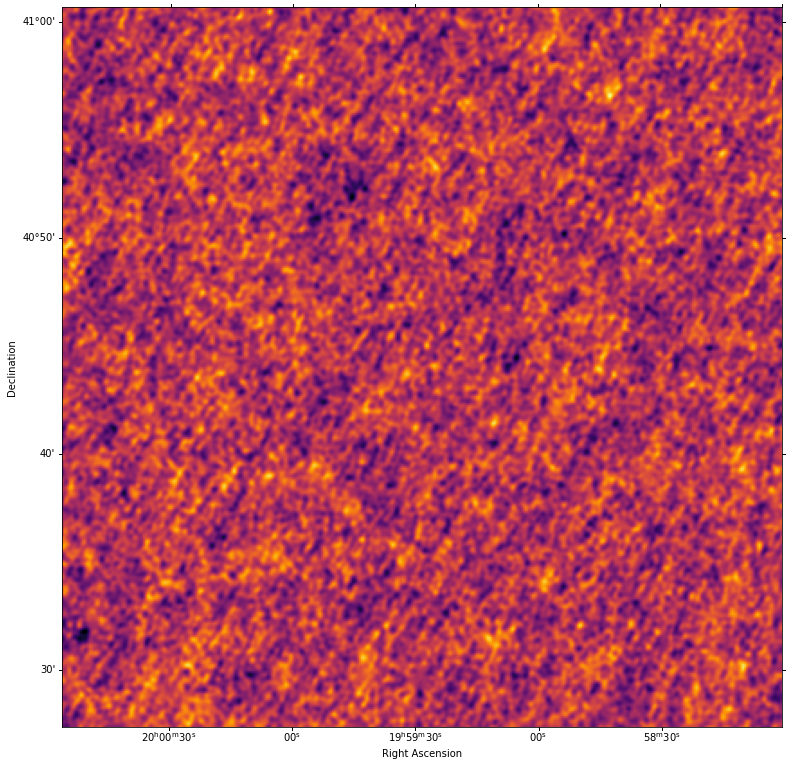

In [6]:
ia = image()
ia.open('simple.image')
csys = ia.coordsys()

w = WCS(naxis=2)

rad_to_deg = 180/np.pi

w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
w.wcs.ctype = ['RA---SIN','DEC--SIN']

data = ia.getchunk()[:, :, 0, 0]

fig, ax = plt.subplots(figsize=(15, 10))
fig.delaxes(ax)

ax = fig.add_axes(rect=[1, 1, 1, 1], projection=w)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

ax.imshow(data, origin='lower', cmap='inferno')

In [7]:
import IPython

IPython.display.Markdown('### Noise RMS:\n' + str(data.std()))

### Noise RMS:
1.9867504548950506e-05

## Theoretical Calculation of RMS

In [8]:
rms = calc_flux_density(
    n_t=10,
    n_pol=2,
    n_chan=3,
    n_a=27
)

rms

2.0080697558636014e-05

In [9]:
IPython.display.Markdown('## Noise RMS Comparison: \n Theory: {0} \n\n Analytical: {1}'.format(rms, str(data.std())))

## Noise RMS Comparison: 
 Theory: 2.0080697558636014e-05 

 Analytical: 1.9867504548950506e-05